# Basic Use

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

%matplotlib inline

## Read and display magnetic geometry
- In this example, we read an already extracted geometry from a pickle file and plot the inner and outer leg.
- You will need to prepare your own from an equilibrium or SOLPS balance file using SOLPSreader.py.



<Axes: xlabel='$S_{\\parallel}$ (m from target)', ylabel='$B_{tot}$ (T)'>

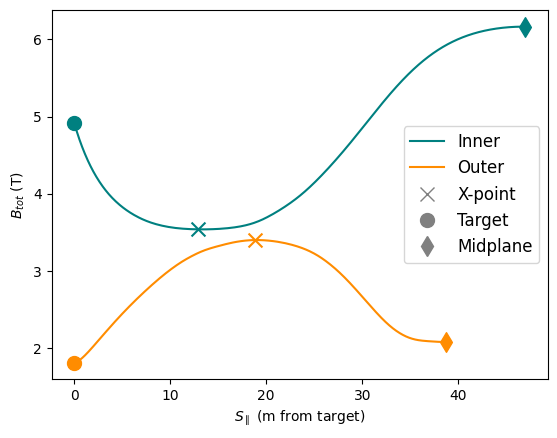

In [2]:
from fusiondls import file_read
from fusiondls.plot import plot_B_field_profile

eqb = file_read("eqb_store.pkl")
inner = eqb["V10"]["iu"]  # Inner upper
outer = eqb["V10"]["ou"]  # Outer upper
plot_B_field_profile(
    inner["S"],
    inner["Btot"],
    inner["Xpoint"],
    outer["S"],
    outer["Btot"],
    outer["Xpoint"],
)

## Run DLS-Extended
- Solving for 5 front positions equally spaced along the parallel connection length for the outer upper target

### Define DLS settings

Running DLS-Extended requires a `MagneticGeometry`, which defines the magnetic profile from the midplane to the target, and a `SimulationInputs`, which defines other simulation settings.

In [3]:
from fusiondls import MagneticGeometry, SimulationInputs
from fusiondls.analytic_cooling_curves import LfuncKallenbach

geometry = MagneticGeometry.from_pickle("eqb_store.pkl", "V10", "ou")

SparRange = np.linspace(0, geometry.Sparx, 5)

settings = SimulationInputs(
    control_variable="density",  # One of 'density', 'impurity_frac' or 'power'
    SparRange=SparRange,  # List of S_parallel values to solve for
    qpllu0=1e9,  # Constant heat flux density at the x point
    nu0=1e20,  # Initial upstream density
    cz0=0.02,  # Constant mpurity fraction
    cooling_curve=LfuncKallenbach("Ar"),  # impurity cooling function
)

### Run

In [4]:
from fusiondls import run_dls

results = run_dls(settings, geometry)

## Post-processing

### Front position history
- cvar is the control variable we are solving for, in this case density
- crel is the relative control variable (normalised to 1 at threshold) - useful for comparison between cases.

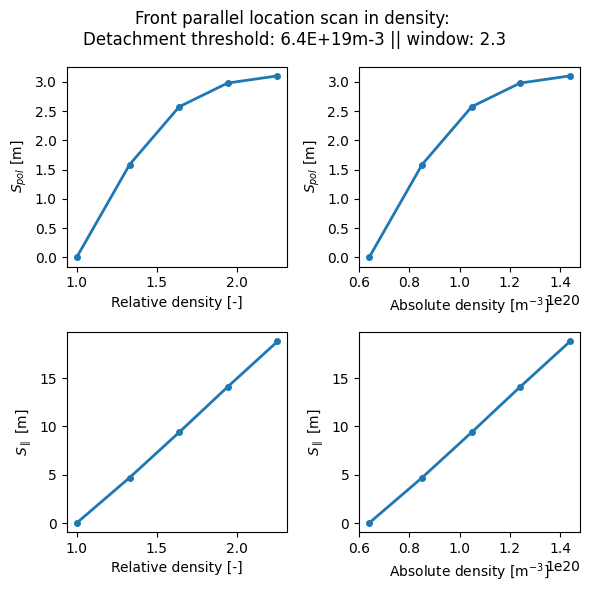

In [5]:
from fusiondls.postprocessing import FrontLocationScan

scan = FrontLocationScan(results)

fig, axes = plt.subplots(2, 2, figsize=(6, 6))
fig.suptitle(
    f"Front parallel location scan in density: \nDetachment threshold: {scan.threshold:.1E}m-3 || window: {scan.window_ratio:.1f}",
    fontsize=12,
)

# Relative control variable against poloidal length (default)
scan.plot_front_movement(ax=axes[0, 0])
# Absolute control variable against poloidal length
scan.plot_front_movement(ax=axes[0, 1], relative=False)
# Relative control variable against parallel length
scan.plot_front_movement(ax=axes[1, 0], parallel=True)
# Absolute control variable against parallel length
scan.plot_front_movement(ax=axes[1, 1], parallel=True, relative=False)

[ax.set_ylabel(r"$S_{pol}$ [m]") for ax in axes[0, :]]
[ax.set_ylabel(r"$S_{\parallel}$ [m]") for ax in axes[1, :]]

[ax.set_xlabel(r"Relative density [-]") for ax in axes[:, 0]]
[ax.set_xlabel(r"Absolute density $\mathrm{[m^{-3}]}$") for ax in axes[:, 1]]

fig.tight_layout()

### Tests

Verify that the control variable and parallel position arrays are as expected.

In [6]:
np.testing.assert_allclose(
    scan.data["cvar"],
    [6.39460377e19, 8.50407130e19, 1.04820590e20, 1.24066606e20, 1.43924591e20],
    err_msg="FAIL - front scan test, cvar",
)
np.testing.assert_allclose(
    scan.data["Spol"],
    [0.0, 1.58654208, 2.57608158, 2.97983262, 3.10262434],
    err_msg="FAIL - front scan test, Splot",
)

## Profiles of plasma properties for individual front positions
- By default DLS-Extended uses a grid refined around the front location
- This means it's different for each front position
- The profiles of S, Spol as well as process variables (T, qpar/Q, R, etc) are provided on a per front location basis

Text(0.5, 1.05, 'Radiated power, parallel heat flux and temperature for two front positions')

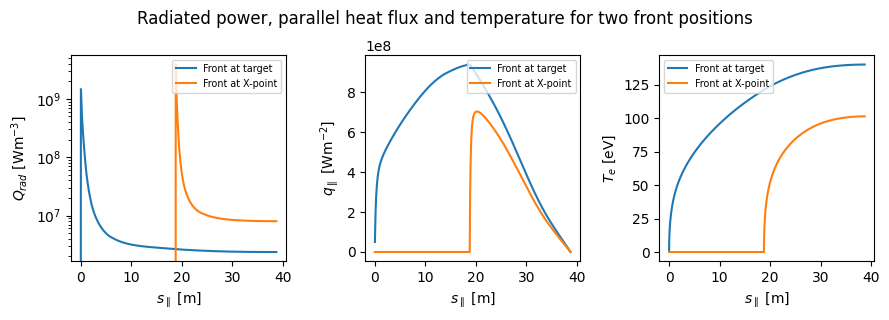

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
labels = ["Front at target", "Front at X-point"]

## Plot 1D profiles along field line for the first and final front solution in the scan
for i, position_index in enumerate([0, -1]):
    front_solution = scan.FrontLocations[position_index]

    axes[0].plot(
        front_solution.data["Spar"],
        front_solution.data["Qrad"],
        label=labels[i],
    )

    axes[1].plot(
        front_solution.data["Spar"],
        front_solution.data["qpar"],
        label=labels[i],
    )
    axes[2].plot(
        front_solution.data["Spar"],
        front_solution.data["Te"],
        label=labels[i],
    )

axes[0].set_ylabel(r"$Q_{rad}\ \mathrm{[Wm^{-3}]}$")
axes[1].set_ylabel(r"$q_{\parallel}\ \mathrm{[Wm^{-2}]}$")
axes[2].set_ylabel(r"$T_{e}\ \mathrm{[eV]}$")
axes[0].set_yscale("log")
for ax in axes:
    ax.set_xlabel(r"$s_{\parallel}\ \mathrm{[m]}$")
    ax.legend(fontsize="x-small")

fig.tight_layout()
fig.suptitle(
    "Radiated power, parallel heat flux and temperature for two front positions", y=1.05
)

### Tests

Verify that the integrals of the above profiles are as expected.

In [8]:
cases = ["target", "Xpoint"]
integrals = {"radiation": {}, "heatflux": {}, "temperature": {}}

for i, position_index in enumerate([0, -1]):
    front_solution = scan.FrontLocations[position_index]

    Qrad = front_solution.data["Qrad"]
    S = front_solution.data["Spar"]
    qpar = front_solution.data["qpar"]
    Te = front_solution.data["Te"]

    name = cases[i]
    integrals["radiation"][name] = sp.integrate.trapezoid(Qrad, S)
    integrals["heatflux"][name] = sp.integrate.trapezoid(qpar, S)
    integrals["temperature"][name] = sp.integrate.trapezoid(Te, S)


reference_integrals = {
    "radiation": {"target": 523226999.38597214, "Xpoint": 894932594.5255164},
    "heatflux": {"target": 23239029534.052227, "Xpoint": 7495964202.588931},
    "temperature": {"target": 4346.077975186298, "Xpoint": 1732.7529664551957},
}

for key, subdict in integrals.items():
    for subkey, value in subdict.items():
        ref_value = reference_integrals[key][subkey]
        np.testing.assert_allclose(
            value, ref_value, err_msg=f"FAIL - {key} profile at {subkey}", rtol=1e-3
        )